In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score

from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)

In [2]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
# Load (preprocessed) data
# 
# The raw data was downloaded from https://data.stanford.edu/hcmst and preprocessed.
# We combined data sets collected across several years, we transformed select variables 
# (e.g., partner_education to be at the same level of granularity as education),
# and added variables like the absolute age difference, education difference, etc.
# Finally, we determined whether couples were still together (i.e., our labels).
#
# We provide the preprocessed data as a csv file in the same repo as this notebook.

df = pd.read_csv('couples.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['age',
                 'partner_age',
                 'age_diff_abs',
                 'children',
                 'visits_relatives',
                 'education',
                 'marital_status',
                 'partner_education',
                 'gender',
                 'house',
                 'income',
                 'msa',
                 'rent',
                 'political',
                 'religion',
                 'work',
                 'gender_older',
                 'education_difference',
                 'success']

data = df[feature_order]
data = data[data.house != 'boat, rv, van, etc.'] # only one data point with this value, discard

labels = data.pop('success')

In [4]:
# Take a peak at the data
data.head()

,age,partner_age,age_diff_abs,children,visits_relatives,education,marital_status,partner_education,gender,house,income,msa,rent,political,religion,work,gender_older,education_difference
0,52,48,4,0.0,0,bachelor's degree or higher,living with partner,some college,female,a building with 2 or more apartments,"$20,000 to $24,999",metro,rented for cash,democrat,catholic,working - as a paid employee,1,1
1,28,30,2,0.0,0,bachelor's degree or higher,living with partner,bachelor's degree or higher,female,a building with 2 or more apartments,"$40,000 to $49,999",metro,rented for cash,democrat,jewish,working - as a paid employee,0,0
2,31,40,9,0.0,1,some college,never married,high school,male,a building with 2 or more apartments,"$40,000 to $49,999",metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,1,1
3,53,55,2,0.0,1,bachelor's degree or higher,living with partner,bachelor's degree or higher,male,a one-family house detached from any other house,"$125,000 to $149,999",metro,owned or being bought by you or someone in you...,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,1,0
4,58,51,7,0.0,0,bachelor's degree or higher,separated,bachelor's degree or higher,male,a building with 2 or more apartments,"$15,000 to $19,999",metro,rented for cash,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,0,0


In [5]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[0:5])
continuous_idx = list(range(0,5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)

In [6]:
labels_train.unique(), labels_test.unique()

(array([ 1.,  0.]), array([ 1.,  0.]))

In [7]:
# Preprocessing pipeline
#      
# LIME needs a function that takes raw inputs and returns a prediction (see below).     
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below). 
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [8]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from functools import partial
from math import log, exp

In [9]:
dtrain = xgb.DMatrix(train, label=labels_train)

In [10]:
num_round = 900

defaults = {
    'objective': 'binary:logistic',
    'silent': True
}

trials = Trials()
the_best = 0


def hyperopt_train_test(params):

    global the_best
    
    params["max_depth"] +=1
    params["eta"] = exp(params["eta"])
    params.update(defaults)
    
    r = xgb.cv(params, dtrain, num_round, nfold=7,
               metrics={'auc'},
               early_stopping_rounds=40)
   
    weight = float(r.tail(1)["test-auc-mean"])
    
    if the_best > -weight:
        the_best = -weight
        print(params, " => ", -weight)
        print(r.tail(1))
    
    return -weight


space4xgb = {
    'max_depth':        hp.choice('max_depth', range(0, 10)),
    'eta':              hp.uniform('eta', log(0.03), log(0.5)),
    'gamma':            hp.uniform('gamma', 0, 30),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1.0),
    'subsample':        hp.uniform('subsample', 0.2, 1.0)
}


def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': acc, 'status': STATUS_OK}


best = fmin(f, space4xgb, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=1000, trials=trials)

{'colsample_bylevel': 0.442956278322694, 'colsample_bytree': 0.6535383816437781, 'eta': 0.4316099214635495, 'gamma': 5.319142526326651, 'max_depth': 6, 'subsample': 0.23494805030076318, 'objective': 'binary:logistic', 'silent': True}  =>  -0.8249908571428571
     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
138       0.824991       0.01419        0.906706        0.00622
{'colsample_bylevel': 0.3755515870221428, 'colsample_bytree': 0.6922028017606018, 'eta': 0.4933318456193517, 'gamma': 2.304955053826129, 'max_depth': 6, 'subsample': 0.25663628203396466, 'objective': 'binary:logistic', 'silent': True}  =>  -0.8268924285714288
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
4       0.826892       0.02362        0.856465        0.01352
{'colsample_bylevel': 0.7603133581644854, 'colsample_bytree': 0.3834834347033621, 'eta': 0.14457734847523165, 'gamma': 16.91153502343177, 'max_depth': 10, 'subsample': 0.49448586680280204, 'objective': 'binary:logistic', 'silent'

In [50]:
param = {'max_depth': 7, 
         'learning_rate': 0.118,
         'gamma': 4.3,
         'colsample_bytree': 0.92,
         'colsample_bylevel': 0.80,
         'subsample': 0.41,
         'objective': 'binary:logistic', 
         'silent': 20,
         'n_estimators': 100} # 0.85 / 0.94

param = {'max_depth': 6, 
         'learning_rate': 0.133,
         'gamma': 6.6,
         'colsample_bytree': 0.94,
         'colsample_bylevel': 0.91,
         'subsample': 0.63,
         'objective': 'binary:logistic', 
         'silent': 20,
         'n_estimators': 800} # 0.863 / 0.946


rf = xgb.XGBClassifier(class_weight='balanced')
rf = rf.set_params(**param)

pipeline = rf
pipeline.fit(train, labels_train, 
             eval_set=[(test, labels_test), (train, labels_train)],
             eval_metric="auc",
             verbose=True)

[0]	validation_0-auc:0.799528	validation_1-auc:0.787809
[1]	validation_0-auc:0.807727	validation_1-auc:0.803664
[2]	validation_0-auc:0.803361	validation_1-auc:0.817185
[3]	validation_0-auc:0.837419	validation_1-auc:0.857209
[4]	validation_0-auc:0.842374	validation_1-auc:0.864844
[5]	validation_0-auc:0.842065	validation_1-auc:0.864534
[6]	validation_0-auc:0.8409	validation_1-auc:0.869354
[7]	validation_0-auc:0.843904	validation_1-auc:0.86581
[8]	validation_0-auc:0.856371	validation_1-auc:0.874971
[9]	validation_0-auc:0.858813	validation_1-auc:0.875694
[10]	validation_0-auc:0.855472	validation_1-auc:0.874902
[11]	validation_0-auc:0.857059	validation_1-auc:0.882031
[12]	validation_0-auc:0.855486	validation_1-auc:0.880581
[13]	validation_0-auc:0.854139	validation_1-auc:0.881108
[14]	validation_0-auc:0.853423	validation_1-auc:0.888366
[15]	validation_0-auc:0.853633	validation_1-auc:0.889469
[16]	validation_0-auc:0.855823	validation_1-auc:0.892223
[17]	validation_0-auc:0.855767	validation_1-

[144]	validation_0-auc:0.859838	validation_1-auc:0.924427
[145]	validation_0-auc:0.859838	validation_1-auc:0.924427
[146]	validation_0-auc:0.859838	validation_1-auc:0.924427
[147]	validation_0-auc:0.859838	validation_1-auc:0.924427
[148]	validation_0-auc:0.859838	validation_1-auc:0.924427
[149]	validation_0-auc:0.859838	validation_1-auc:0.924427
[150]	validation_0-auc:0.859838	validation_1-auc:0.924427
[151]	validation_0-auc:0.859838	validation_1-auc:0.924427
[152]	validation_0-auc:0.859838	validation_1-auc:0.924427
[153]	validation_0-auc:0.859894	validation_1-auc:0.925856
[154]	validation_0-auc:0.860681	validation_1-auc:0.927684
[155]	validation_0-auc:0.860681	validation_1-auc:0.927681
[156]	validation_0-auc:0.860681	validation_1-auc:0.927684
[157]	validation_0-auc:0.860681	validation_1-auc:0.927681
[158]	validation_0-auc:0.860681	validation_1-auc:0.927684
[159]	validation_0-auc:0.860681	validation_1-auc:0.927684
[160]	validation_0-auc:0.860681	validation_1-auc:0.927684
[161]	validati

[286]	validation_0-auc:0.857059	validation_1-auc:0.934029
[287]	validation_0-auc:0.857059	validation_1-auc:0.934029
[288]	validation_0-auc:0.857957	validation_1-auc:0.935383
[289]	validation_0-auc:0.857957	validation_1-auc:0.935383
[290]	validation_0-auc:0.857957	validation_1-auc:0.935383
[291]	validation_0-auc:0.857957	validation_1-auc:0.935383
[292]	validation_0-auc:0.857957	validation_1-auc:0.935383
[293]	validation_0-auc:0.857957	validation_1-auc:0.935383
[294]	validation_0-auc:0.857957	validation_1-auc:0.935383
[295]	validation_0-auc:0.857957	validation_1-auc:0.935383
[296]	validation_0-auc:0.857957	validation_1-auc:0.935383
[297]	validation_0-auc:0.857957	validation_1-auc:0.935383
[298]	validation_0-auc:0.857957	validation_1-auc:0.935383
[299]	validation_0-auc:0.857957	validation_1-auc:0.935383
[300]	validation_0-auc:0.857957	validation_1-auc:0.935383
[301]	validation_0-auc:0.858856	validation_1-auc:0.935667
[302]	validation_0-auc:0.858856	validation_1-auc:0.935667
[303]	validati

[428]	validation_0-auc:0.864078	validation_1-auc:0.938718
[429]	validation_0-auc:0.864078	validation_1-auc:0.938718
[430]	validation_0-auc:0.864078	validation_1-auc:0.938718
[431]	validation_0-auc:0.864078	validation_1-auc:0.938718
[432]	validation_0-auc:0.864078	validation_1-auc:0.938718
[433]	validation_0-auc:0.864078	validation_1-auc:0.938718
[434]	validation_0-auc:0.864078	validation_1-auc:0.938718
[435]	validation_0-auc:0.864078	validation_1-auc:0.938718
[436]	validation_0-auc:0.864078	validation_1-auc:0.938718
[437]	validation_0-auc:0.864078	validation_1-auc:0.938718
[438]	validation_0-auc:0.864078	validation_1-auc:0.938718
[439]	validation_0-auc:0.864078	validation_1-auc:0.938718
[440]	validation_0-auc:0.864078	validation_1-auc:0.938718
[441]	validation_0-auc:0.864078	validation_1-auc:0.938718
[442]	validation_0-auc:0.864078	validation_1-auc:0.938718
[443]	validation_0-auc:0.864078	validation_1-auc:0.938718
[444]	validation_0-auc:0.864078	validation_1-auc:0.938718
[445]	validati

[570]	validation_0-auc:0.863208	validation_1-auc:0.940393
[571]	validation_0-auc:0.863208	validation_1-auc:0.940393
[572]	validation_0-auc:0.863208	validation_1-auc:0.940393
[573]	validation_0-auc:0.863208	validation_1-auc:0.940393
[574]	validation_0-auc:0.863208	validation_1-auc:0.940393
[575]	validation_0-auc:0.863208	validation_1-auc:0.940393
[576]	validation_0-auc:0.863208	validation_1-auc:0.940393
[577]	validation_0-auc:0.86346	validation_1-auc:0.940666
[578]	validation_0-auc:0.86346	validation_1-auc:0.940666
[579]	validation_0-auc:0.86346	validation_1-auc:0.940666
[580]	validation_0-auc:0.86346	validation_1-auc:0.940666
[581]	validation_0-auc:0.86346	validation_1-auc:0.940666
[582]	validation_0-auc:0.86346	validation_1-auc:0.940666
[583]	validation_0-auc:0.86346	validation_1-auc:0.940666
[584]	validation_0-auc:0.86346	validation_1-auc:0.940666
[585]	validation_0-auc:0.86346	validation_1-auc:0.940666
[586]	validation_0-auc:0.86346	validation_1-auc:0.940666
[587]	validation_0-auc:0

[713]	validation_0-auc:0.864022	validation_1-auc:0.942417
[714]	validation_0-auc:0.864022	validation_1-auc:0.942417
[715]	validation_0-auc:0.864022	validation_1-auc:0.942417
[716]	validation_0-auc:0.864022	validation_1-auc:0.942417
[717]	validation_0-auc:0.864022	validation_1-auc:0.942417
[718]	validation_0-auc:0.864022	validation_1-auc:0.942417
[719]	validation_0-auc:0.864022	validation_1-auc:0.942417
[720]	validation_0-auc:0.864022	validation_1-auc:0.942417
[721]	validation_0-auc:0.864022	validation_1-auc:0.942417
[722]	validation_0-auc:0.864022	validation_1-auc:0.942417
[723]	validation_0-auc:0.864022	validation_1-auc:0.942417
[724]	validation_0-auc:0.864022	validation_1-auc:0.942417
[725]	validation_0-auc:0.864022	validation_1-auc:0.942417
[726]	validation_0-auc:0.864022	validation_1-auc:0.942417
[727]	validation_0-auc:0.864022	validation_1-auc:0.942417
[728]	validation_0-auc:0.864022	validation_1-auc:0.942417
[729]	validation_0-auc:0.864022	validation_1-auc:0.942417
[730]	validati

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=0.91, colsample_bytree=0.94, gamma=6.6,
       learning_rate=0.133, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=20,
       subsample=0.63)

In [52]:
# Evalute random forest classifier on training data (it overfits, small sample size)
y_predict = pipeline.predict(train)
f1 = f1_score(labels_train, y_predict)
print('F1 on train:', f1)

# Evalute random forest classifier on train data
y_predict = pipeline.predict_proba(train)[:,1]
auc = roc_auc_score(labels_train, y_predict)
print('AUC on train:', auc)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
f1 = f1_score(labels_test, y_predict)
print('F1 on test:', f1)

# Evalute random forest classifier on test data
y_predict = pipeline.predict_proba(test)[:,1]
auc = roc_auc_score(labels_test, y_predict)
print('AUC on test:', auc)

F1 on train: 0.933497536946
AUC on train: 0.946005620233
F1 on test: 0.88202247191
AUC on test: 0.863151392633


0.7601809954751131


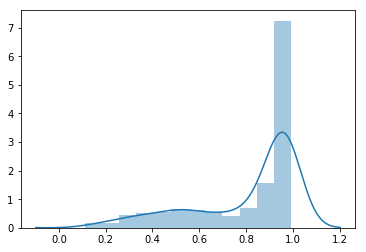

In [53]:
import seaborn as sns
%matplotlib inline

print(labels_test.mean())

sns.distplot(y_predict)

In [54]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    train,
    class_names=['BrokeUp', 'StayedTogether'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

Couples probability of staying together: 0.905082


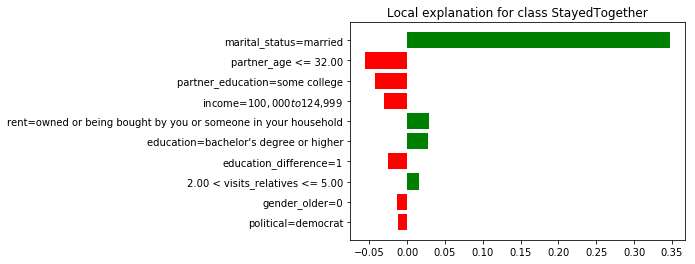

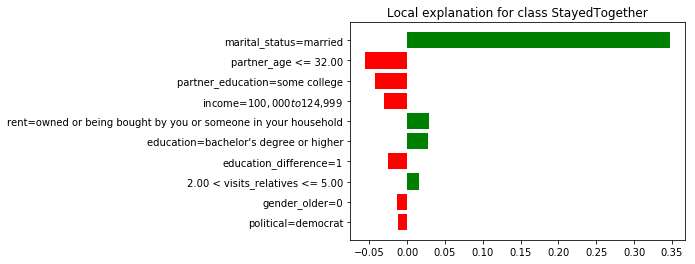

In [55]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.926668


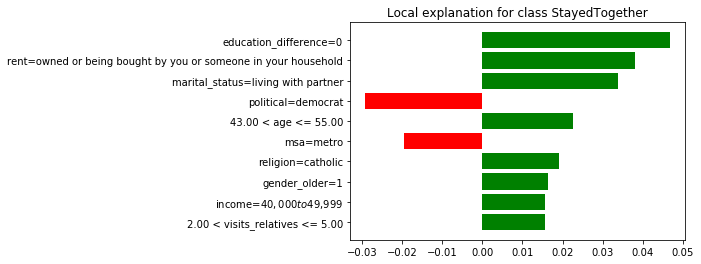

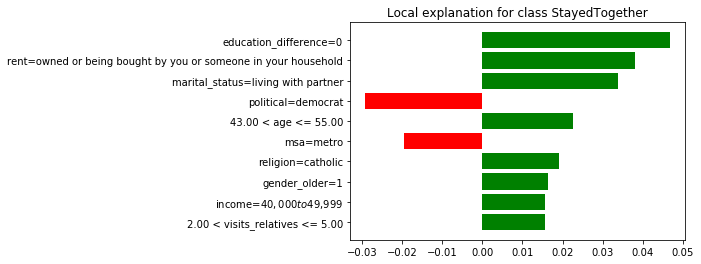

In [56]:
# Explain another prediction ("local interpretability"): 
example = 13
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [57]:
# and we see differences in explaining the model's predictions.

Couples probability of staying together: 0.870143


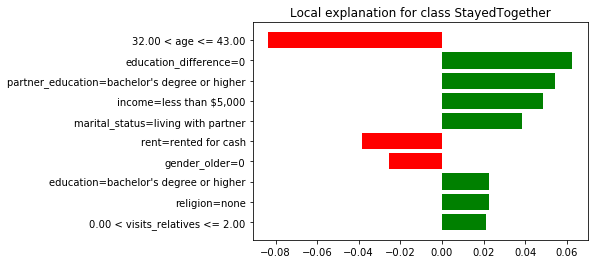

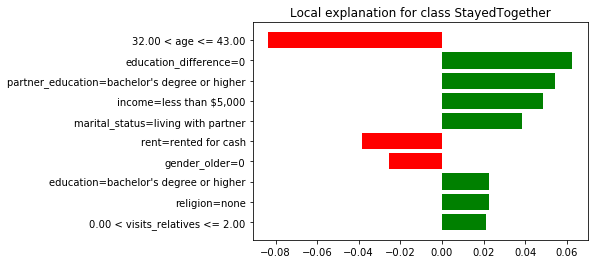

In [58]:
# Using LIME for for relationship management (not advised): Current chance of relationship success.
current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 18, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(current), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.796474


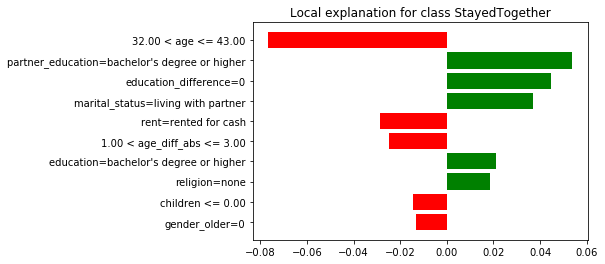

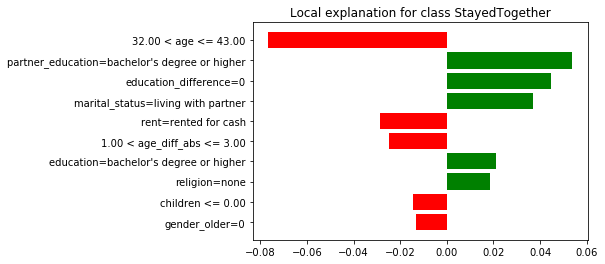

In [59]:
# Should I ask for a pay increase? It doesn't matter much.
increase_income = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(increase_income), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.826882


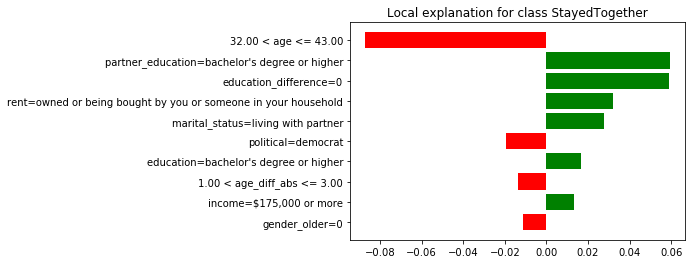

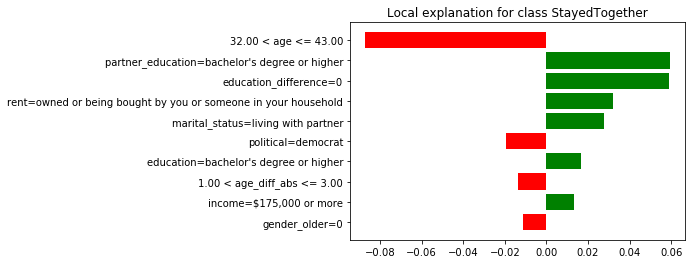

In [60]:
# Should I buy a house? Maybe?
buy_house = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(buy_house), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.950146


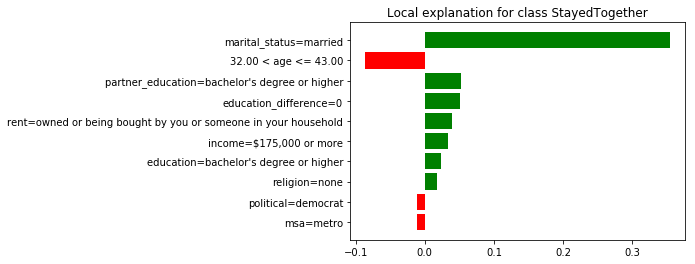

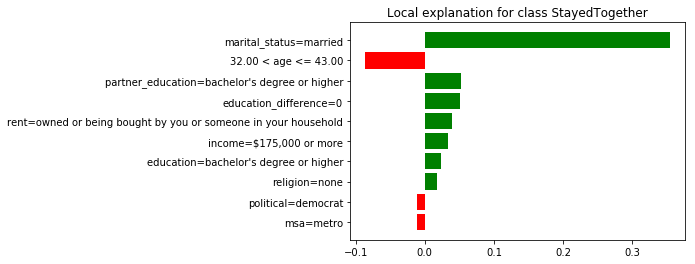

In [61]:
# Really, it's best to get married.
get_married = [34, 36, 2, 0, 1, 0, 2, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(get_married), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()